#**Case Study 1 : APS Failure prediction on Scania Trucks**

#Business Problem
Air Pressure System failure is a common problem in heavy vehicles. The service cost and maintenance cost for such failures is high. i.e. if a vehicle breaks down because of APS failure, its repairing cost is high. Also, the cost for checking APS failure in these heavy vechicles everytime is high.

So, the task at hand is to come up with a solution that would help in predicting this failure in trucks, thereby preventing or reducing the maintenance cost involved. 

#Why ML?
If we can build a ML model that would help in predicting the APS failure in trucks effectively, then we can save the time and cost involved in addressing such failures. 

The cost involved in addressing APS failures is trucks is explained as follows :<br>

__Total cost = cost 1 * no of instances + cost 2 * no of instances__ <br> 

Cost 1 : Corresponds to cases where an unnecessary check needs to be done by the mechanic. i.e. checking for APS failure on trucks that doesn't have this failure. <br>

Cost 2 : Corresponds cases of missing to identify a truck that actually had APS failure which may cause a breakdown. This breakdown cost is high. 

Our objective is to build a model that can reduce this total cost as low as possible.



#Business Constraints :
1. Reduce the cost of misclassification. i.e reduce the total cost as discussed above. 

2. Low latency. Model should be able to predict the failure in trucks in seconds.

#Performance Metric :
We will use __Macro f1 Score__ as the performance metric. Macro f1 score takes into account f1 score of each class separately and computes the average of it. This metric also works well with imbalanced datasets. <br>
Since the cost of miscalssification is high for this problem, our model should have high precision and recall. F1 score is a good metric that combines precision and recall. 

#Get the dataset from below link:
1. https://ida2016.blogs.dsv.su.se/?page_id=1387

2. https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set?select=aps_failure_test_set.csv

#Importing Libraries

In [287]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

#Loading the Train Dataset

In [14]:
df_train = pd.read_csv('/content/data/ida_2016_challenge_update/ida_2016_training_set_update.csv')
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
df_train.shape

(60000, 171)

__Observation : The datset set has 60000 datapoints and 171 features including class label.__

In [ ]:
df_train.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

#Data Cleaning for Train Dataset

###Replacing positive class label with 1 and negative class label with 0. 

In [15]:
df_train['class'] = df_train['class'].replace(['pos','neg'],[1,0])
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,0,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


###Checking for data imbalance

In [ ]:
df_train['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

__Observation : The dataset is highly imbalanced with majority of datapoints belonging to negative class.__

###Replacing missing values 'na' with np.nan

In [16]:
df_train = df_train.replace('na',np.NaN)
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


###Removing features with zero variance. 

In [17]:
df_train = df_train.astype(float)
for i in df_train:
  if df_train[i].std() == 0:
    df_train = df_train.drop([i],axis=1)
    print('The feature with zero variance is : ',i)
df_train.shape

The feature with zero variance is :  cd_000


(60000, 170)

__There was one feature that had zero variance. That feature is eliminated and we are left with 170 features.__

##Removing Duplicate rows and columns

In [18]:
df_train = df_train.drop_duplicates(keep = 'first')
df_train = df_train.T.drop_duplicates().T
print(df_train.shape)

(59999, 170)


__One duplicate row is eliminated, there are no other duplicates.__

#Data Cleaning for Test Dataset

In [19]:
import pandas as pd
df_test = pd.read_csv("/content/aps_failure_test_set.csv")

In [20]:
df_test['class'] = df_test['class'].replace(['pos','neg'],[1,0])
df_test = df_test.replace('na',np.NaN)
df_test = df_test.astype(float)
for i in df_test:
  if df_test[i].std() == 0:
    df_test = df_test.drop([i],axis=1)
    print('The feature with zero variance is : ',i)

df_test = df_test.drop_duplicates(keep = 'first')
df_test = df_test.T.drop_duplicates().T
print(df_test.shape)

The feature with zero variance is :  cd_000
(16000, 170)


#Exploratory Data Analysis

##Checking the percentage of missing values for each feature.

In [21]:
missing_feature_count = dict(df_train.drop('class',axis=1).isnull().sum())
missing_feature_count = dict(sorted(missing_feature_count.items(), key=lambda item:item[1],reverse=True))

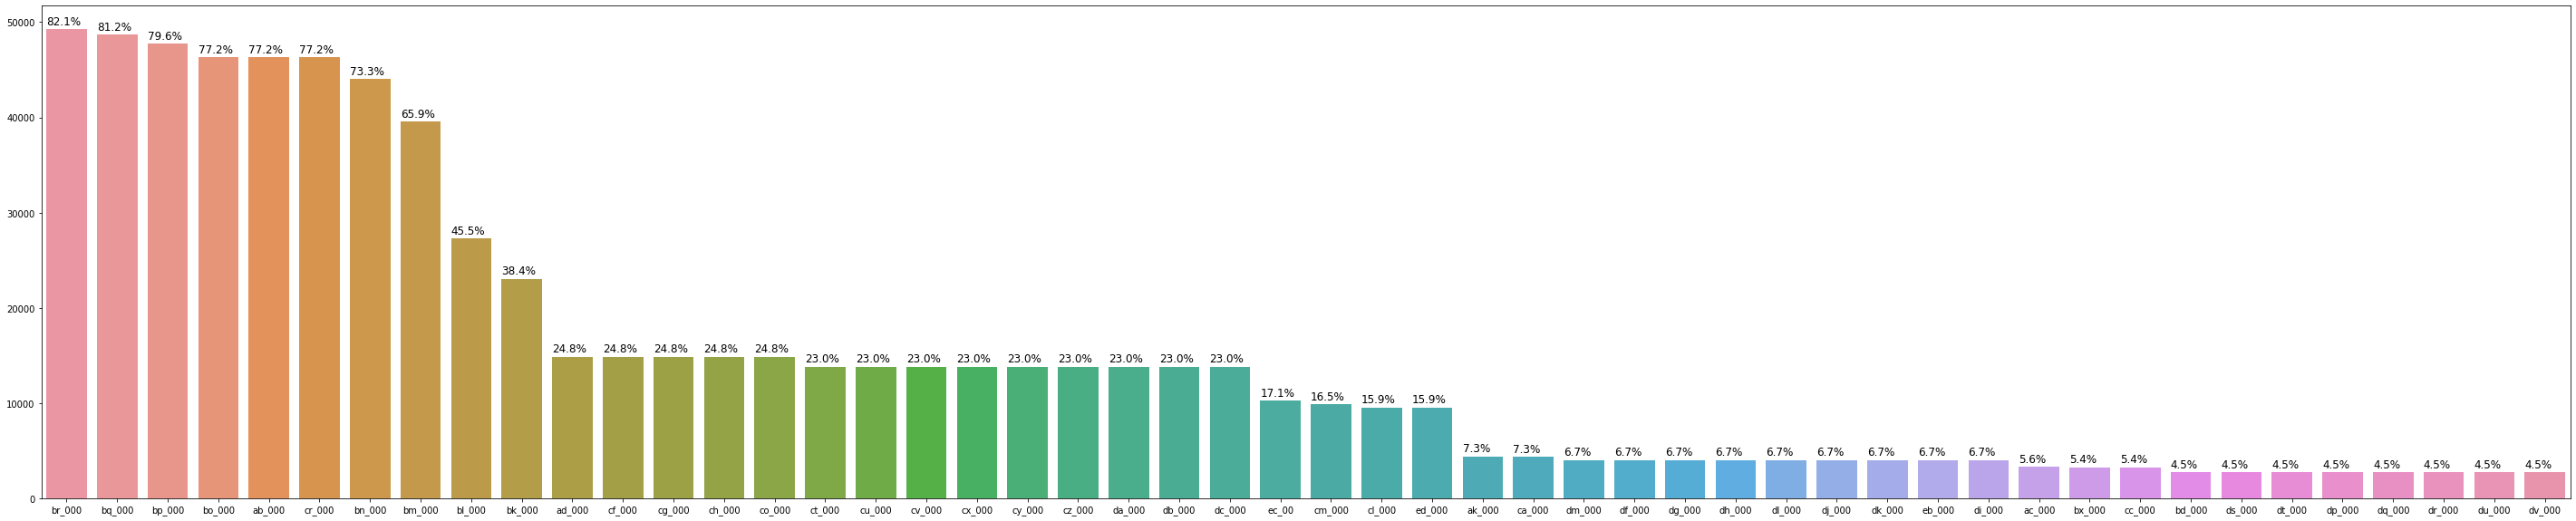

In [ ]:
#https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot
def barplot(data,sum):
  plt.figure(figsize = (50,10))
  ax = sns.barplot(x = list(data.keys())[:50], y = list(data.values())[:50])

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/sum)
    x = p.get_x() 
    y = p.get_height()+500
    ax.annotate(percentage,(x,y),size=12)
barplot(missing_feature_count,df.shape[0])

###Observations:
1. 8 features have missing values greater than 60%. 

2. 16 features have missing value between 20% - 60%

3. All the remaining features have missing value less than 20%

##Separating Histogram and Non-Histogram features from the dataset

In [ ]:
hist_col = []
for i in df_train.columns:
  if i[-1] != '0':
    hist_col.append(i)
hist_col.extend(['ag_000','ay_000','az_000','ba_000','cn_000','cs_000','ee_000'])

hist_features = df_train[hist_col]
hist_features = hist_features.drop('class',axis=1)
num_features = df_train.drop(hist_col,axis=1)


print(hist_features.shape)
print(num_features.shape)

(59999, 70)
(59999, 99)


##Extracting important features using Recursive Feature Elimination
1. Since there are a total of 70 histogram features and 99 non histogram(numerical features), we will take most important features from histogram and numerical features separately and perform EDA on these features.

2. We will use Recursive Feature Elimination technique to get the important features. 

3. Recurcise Feature Elimination(RFE) is a backward feature selection process. RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. Check below link to know more about RFE :
https://machinelearningmastery.com/rfe-feature-selection-in-python/

###Defining Recusive Feature Elimination(RFE) Classifier

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
def top_features_rfe(X,y,n):
  estimator = RandomForestClassifier(max_depth=5)
  rfe = RFE(estimator = estimator, n_features_to_select=n, verbose=0)
  rfe.fit(X,y)
  return (rfe.support_)

###Getting important features from histogram features.

In [ ]:
hist_features['class'] = df_train['class']
imp_hist_features = hist_features.dropna()
y = imp_hist_features['class']
X = imp_hist_features.drop('class',axis=1)
top_hist_features_rfe = top_features_rfe(X,y,10) 
top_hist_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
  if top_hist_features_rfe[i]:
    top_hist_features.append(hist_col[i]) 

print("Top histogram features are : ", top_hist_features)
print("Total no of important features :", len(top_hist_features))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Top histogram features are :  ['ag_001', 'ag_002', 'ag_003', 'ay_005', 'ba_004', 'cn_004', 'cs_002', 'ee_005', 'ba_000', 'cn_000']
Total no of important features : 10


In [ ]:
top_hist_features =  ['ag_001', 'ag_002', 'ag_003', 'ay_005', 'ba_004', 'cn_004', 'cs_002', 'ee_005', 'ba_000', 'cn_000']

###Getting important features from numerical features.

In [ ]:
num_features['class'] = df_train['class']
imp_num_features = num_features.dropna()
y = imp_num_features['class']
X = imp_num_features.drop('class',axis=1)
top_num_features_rfe = top_features_rfe(X,y,10) 
top_num_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
  if top_num_features_rfe[i]:
    top_num_features.append(hist_col[i]) 

print("Top numerical features are : ", top_num_features)
print("Total no of important features :", len(top_num_features))

Top numerical features are :  ['ah_000', 'ai_000', 'al_000', 'am_0', 'aq_000', 'bj_000', 'bk_000', 'cj_000', 'df_000', 'dn_000']
Total no of important features : 10


In [ ]:
top_num_features = ['ah_000', 'ai_000', 'al_000', 'am_0', 'aq_000', 'bj_000', 'bk_000', 'cj_000', 'df_000', 'dn_000']

In [ ]:
hist_features['class'] = df_train['class']
num_features['class'] = df_train['class']
print(hist_features.shape)
print(num_features.shape)

(59999, 71)
(59999, 100)


##Univariate Analysis on top 10 histogram features

####Violin Plots w.r.t target variable

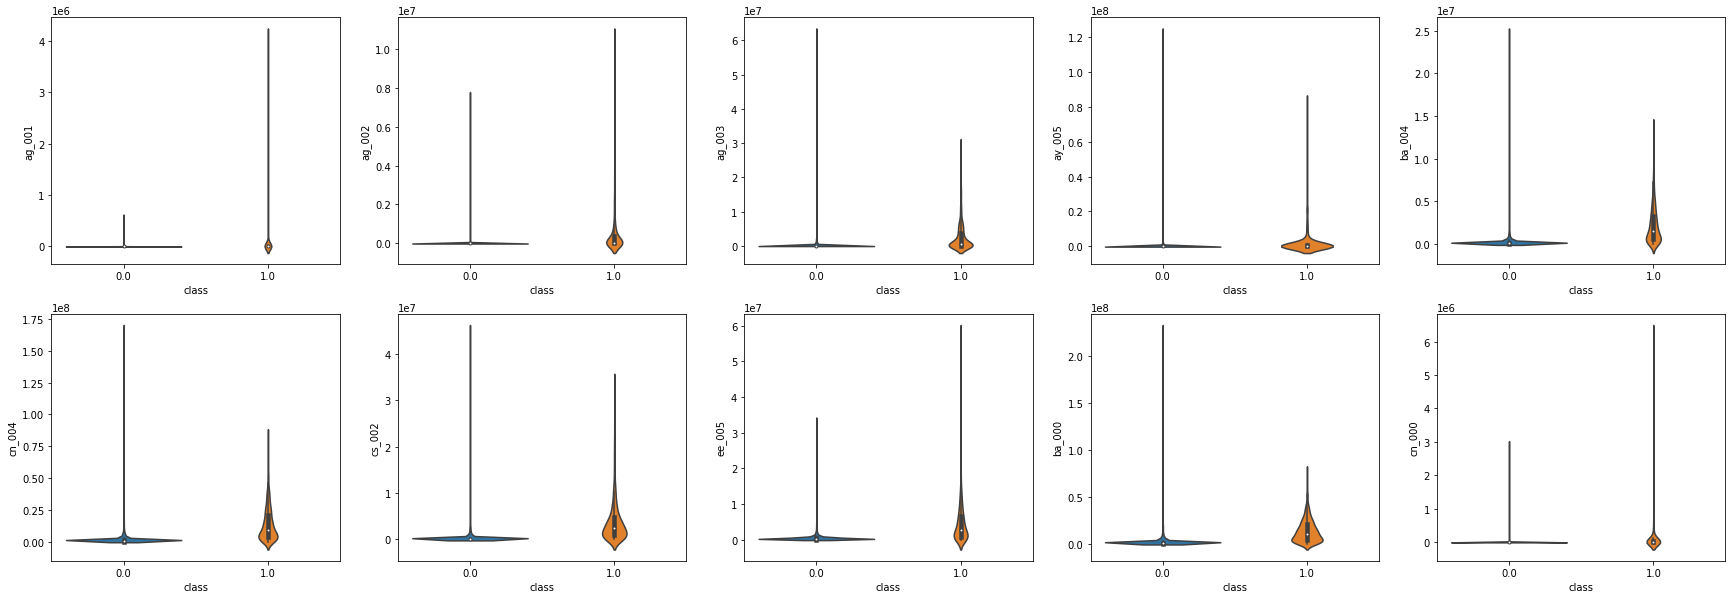

In [ ]:
def violin(df,features,row,col):
  k=0
  fig,axes = plt.subplots(row,col,figsize=(30,10))
  for i in range(len(axes)):
    for j in range(len(axes[0])):
      # plotting violin plot wrt target vriable
      sns.violinplot(x=df['class'],y=features[k], ax= axes[i][j], data=df,size=5)
      if k!= len(features)-1:
        k+=1
      else:
        break
violin(hist_features,top_hist_features,2,5)

###Observations :
1. From the PDF's that we see in the violin plots, majority of the negative datapoints have smaller values compared to the values of positive datapoints. 

2. As the feature value increases, the probability of the datapoint to belong to the positive class also increases. 

3. Considering features [ 'ba_004' , 'cn_004' , 'cs_002' , 'ee_005' , 'ba_000' ] , <br>For negative datapoints, the Inter Quartile Range(IQR) is so small and is barely visible. It takes very small value compared to positive datapoints.<br>For positive datapoints, the IQR is fairly wide and its 25th percentile is much above the IQR of negative datapoints. <br>This means, we can classify the datapoints fairly well using these features. 

4. Features [ 'ag_001' , 'ag_002' , 'ag_003' , 'ay_005' , 'cn_000' ] takes values close to 0 for majority of the negative datapoints. So if these features take value close to 0, chances are high that there is no failure in APS system.<br> 
But as these feature value increases, then chances are high that there is failure in APS system.

__From the violin plot, we see that the features [ 'cn_004' , 'cs_002' , 'ee_005' , 'ba_000' ] are good in classifying the datapoints fairly well. Lets see the percentile values of these features wrt to target variable__

####Checking the percentile value of each features w.r.t. target variable

In [ ]:
f = ['ba_004', 'cn_004', 'cs_002', 'ee_005', 'ba_000']
for i in f:
  print("\nFeature ", i)
  print("Class 0 : 90th percentile : ", np.nanpercentile(hist_features[hist_features['class']==0][i],90))
  print("Class 1 : 25th percentile : ", np.nanpercentile(hist_features[hist_features['class']==1][i],25))



Feature  ba_004
Class 0 : 90th percentile :  361734.0
Class 1 : 25th percentile :  588036.5

Feature  cn_004
Class 0 : 90th percentile :  2281392.0
Class 1 : 25th percentile :  3690910.0

Feature  cs_002
Class 0 : 90th percentile :  256878.40000000078
Class 1 : 25th percentile :  864141.0

Feature  ee_005
Class 0 : 90th percentile :  708216.0000000001
Class 1 : 25th percentile :  847208.0

Feature  ba_000
Class 0 : 90th percentile :  2430826.3999999994
Class 1 : 25th percentile :  4299871.0


__Observations : As you can see, for each feature, the 90th percentile of negative datapoints is coming less than the 25th percentile of positive datapoints. This means around 75% of datapoints can be correctly classified using these features with an error factor of 10%. Now, lets look into the CDF's of these features to get a approximate range for each feature in classifying the dataset.__

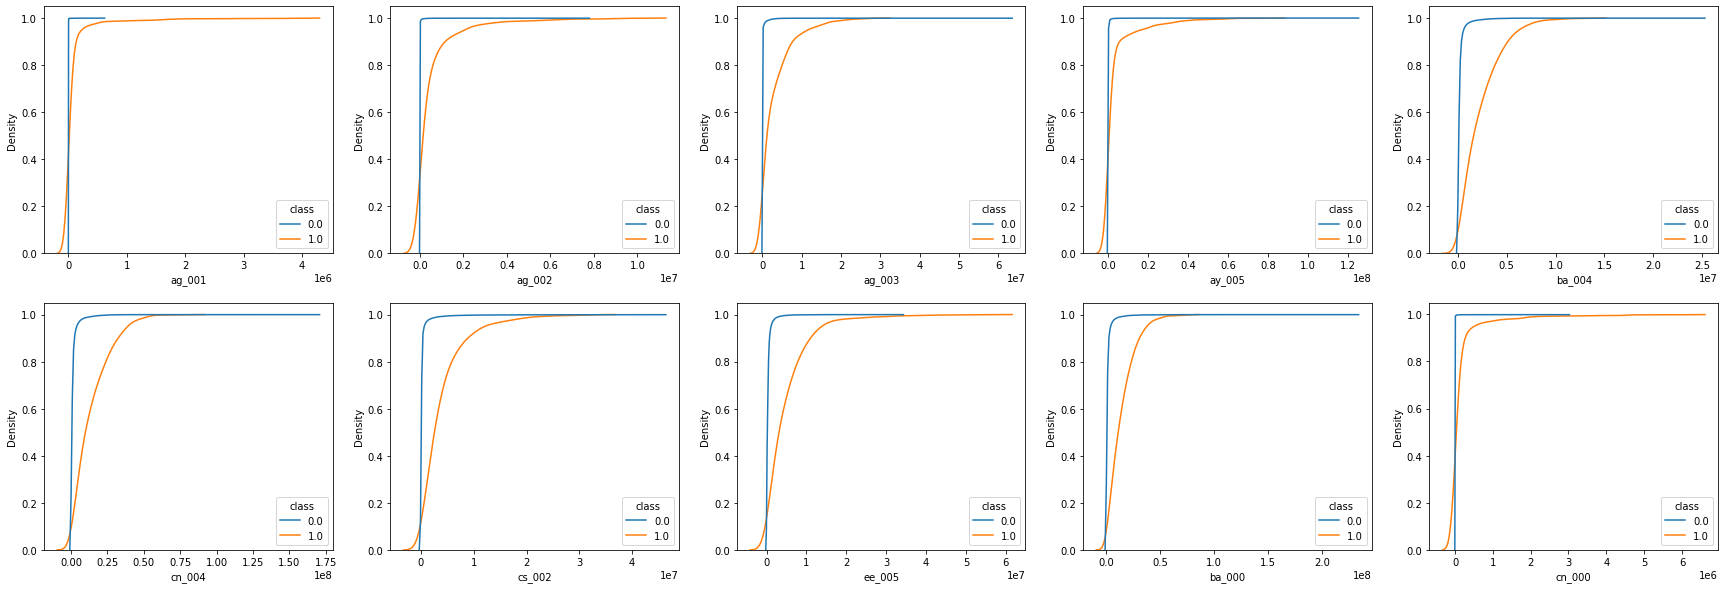

In [ ]:
def cdf(df,features,row,col):
  k=0
  fig,axes = plt.subplots(row,col,figsize=(30,10))
  #plt.title("Color Blue : Negative Class, Color Red : Positive Class")
  for i in range(len(axes)):
    for j in range(len(axes[0])):
      # plotting PDF and CDF 
      #sns.kdeplot(df[df['class']==0][features[k]], ax= axes[i][j],cumulative=True)
      #sns.kdeplot(df[df['class']==1][features[k]], ax= axes[i][j],cumulative=True)   
      sns.kdeplot(x=df[features[k]], data=df, hue='class', cumulative=True, common_norm=False, ax = axes[i][j])
      if k!= len(features)-1:
        k+=1
      else:
        break
cdf(hist_features,top_hist_features,2,5)

###Observations :
1. For features [ 'cn_004' , 'ba_000' ], more than 95% of negative datapoints take feature values less than 0.1 x 10^8 and more that 40% of the positive datapoints take feature values greater than 0.1 x 10^8. This means, around 60% of datapoints can be correctly classified using these features, with 5% error. 

2. For features [ 'ba_004' , 'cs_002' , 'ee_005' ], more than 95% of negative datapoints take feature values less than 0.1 x 10^7 and more that 40% of the positive datapoints take feature values greater than 0.1 x 10^7. This means, around 60% of datapoints can be correctly classified using these features, with 5% error. 
  

##Bivariate Analysis on top 5 histogram features

In [ ]:
hist_features['class'] = df['class']
imp_hist_features = hist_features.dropna()
y = imp_hist_features['class']
X = imp_hist_features.drop('class',axis=1)
top_hist_features_rfe = top_features_rfe(X,y,5) 
top_hist_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
  if top_hist_features_rfe[i]:
    top_hist_features.append(hist_col[i]) 

print("Top histogram features are : ", top_hist_features)
print("Total no of important features :", len(top_hist_features))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Top histogram features are :  ['ag_001', 'ag_002', 'cs_002', 'ee_005', 'ba_000']
Total no of important features : 5


In [ ]:
a = [ 'ag_001', 'ag_002', 'cs_002', 'ee_005', 'ba_000' , 'class']
pairplot_features = hist_features[a]

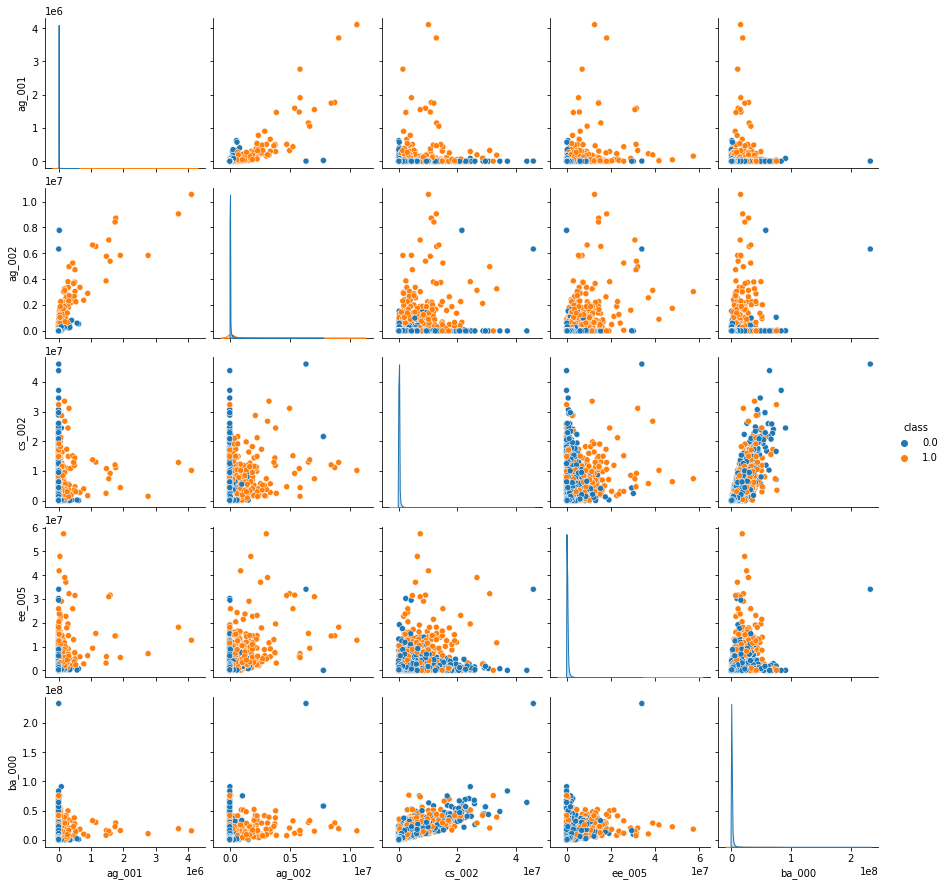

In [ ]:
sns.pairplot(pairplot_features, hue = 'class')

###Observations :
1. If the value of feature 'ag_001' is greater than 0.1 x 10^6, then those datapoints will belong to the positive class. i.e chances are high that there is failure in APS system. This feature is highly uncorrelated with other features ['ba_000' , 'ee_005' , 'cs_002' , 'ag_002'].

1. If the value of feature 'ag_002' is greater than 0.1 x 10^7, then those datapoints will belong to the positive class. i.e chances are high that there is failure in APS system.This feature is highly uncorrelated with other features ['ba_000' , 'ee_005' , 'cs_002' , 'ag_001']. 

2. From the plot between features 'ee_005' vs 'ba_000', if value of feature 'ee_005' is greater than 1x10^7, then chances are high that there is failure in APS. 

3. From the plot between features 'ee_005' vs 'cs_002', if value of feature 'ee_005' is greater than 1x10^7, then chances are high that there is failure in APS. 

4. All the other plots have a lot of overlap and no clear conclusions can be draw from it. 



##Univariate Analysis on numerical features

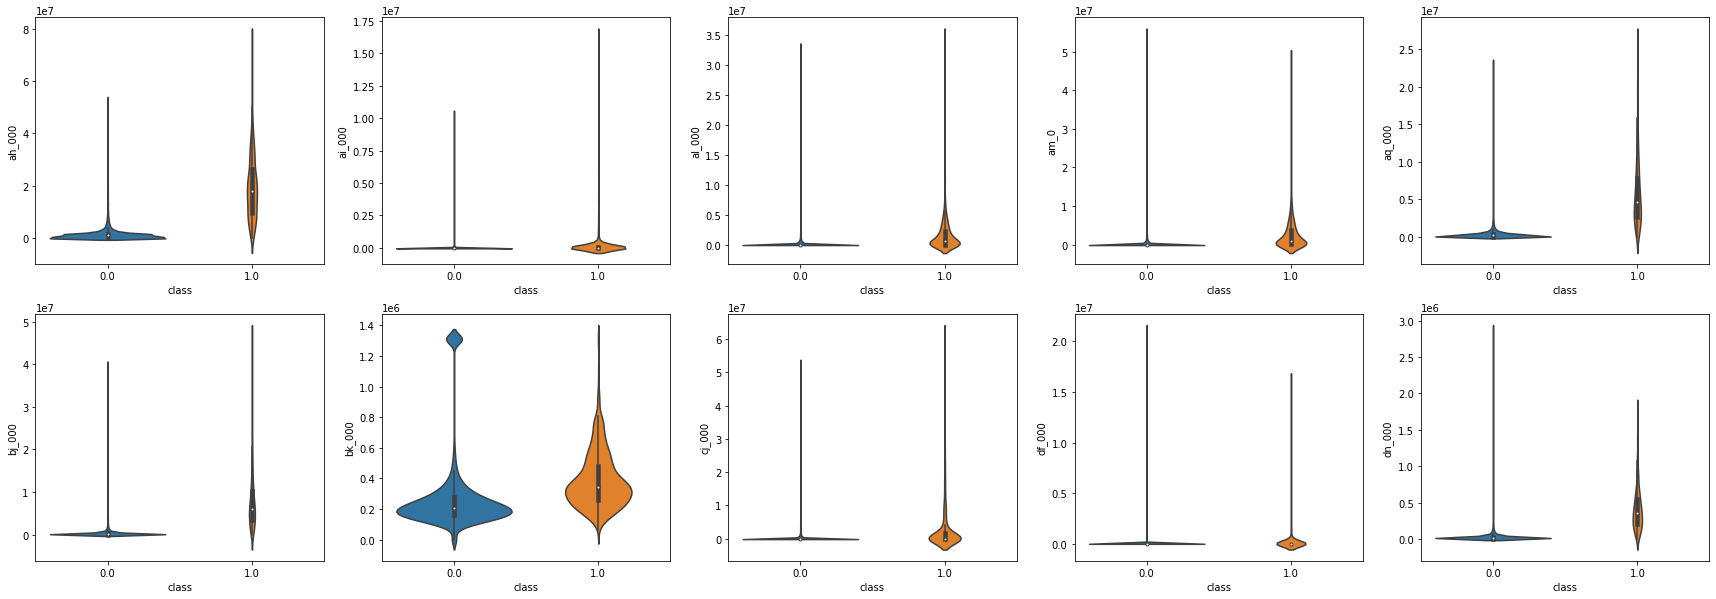

In [ ]:
violin(num_features,top_num_features,2,5)

###Observations :
1. From the PDF's that we see in the violin plots, majority of the negative datapoints have smaller values compared to the values of positive datapoints. 

2. As the feature value increases, the probability of the datapoint to belong to the positive class also increases. 

3. Considering features [ 'ah_000' , 'aq_000' , 'bj_000'  , 'dn_000' ] , <br>For negative datapoints, the Inter Quartile Range(IQR) is so small and is barely visible. It takes very small value compared to positive datapoints.<br>For positive datapoints, the IQR is fairly wide and its 25th percentile is much above the IQR of negative datapoints. <br>This means, we can classify the datapoints fairly well using these features. 

4. For feature 'bk_000', there is a lot of overlap between negative and positive datapoints. Majority of the negative datapoints have values less than 0.5 x 10^6. Also the 75th percentile of the positive datapoints have value close to 0.5 x 10^6. This means around 25% of positive datapoints have values greater than 0.5 x 10 ^6. i.e. if the feature value is greater than 0.5 x 10^6, then chances are high that there is failure in APS system. 

4. Features [ 'ai_000' , 'al_000' , 'am_0' , 'cj_000' , 'df_000' ] takes values close to 0 for majority of the negative datapoints. So if these features have value close to 0, chances are high that there is no failure in APS system.<br> 
But as these feature value increases, then chances are high that there is failure in APS system. 


__From the violin plot, we see that the features[ 'ah_000' , 'aq_000' , 'bj_000'  , 'dn_000' ] are good in classifying the datapoints fairly well. Lets see the percentile values of these features wrt to target variable__

###Checking the percentile value of each feature w.r.t. target variable

In [ ]:
f = [ 'ah_000' , 'aq_000' , 'bj_000' , 'dn_000' ]
for i in f:
  print("\nFeature ", i)
  print("Class 0 : 90th percentile : ", np.nanpercentile(num_features[num_features['class']==0][i],90))
  print("Class 1 : 10th percentile : ", np.nanpercentile(num_features[num_features['class']==1][i],10))



Feature  ah_000
Class 0 : 90th percentile :  3036369.9999999995
Class 1 : 10th percentile :  5105593.600000002

Feature  aq_000
Class 0 : 90th percentile :  728333.2
Class 1 : 10th percentile :  1213968.4000000001

Feature  bj_000
Class 0 : 90th percentile :  695903.1999999998
Class 1 : 10th percentile :  1393952.4000000001

Feature  dn_000
Class 0 : 90th percentile :  52318.2
Class 1 : 10th percentile :  103516.4


__Observations : As you can see, for each feature, the 90th percentile of negative datapoints is coming less than the 10th percentile of positive datapoints. This means around 90% of datapoints can be correctly classified using these features with an error factor of 10%. Now, lets look into the CDF's of these features to get a approximate range for each feature in classifying the dataset.__

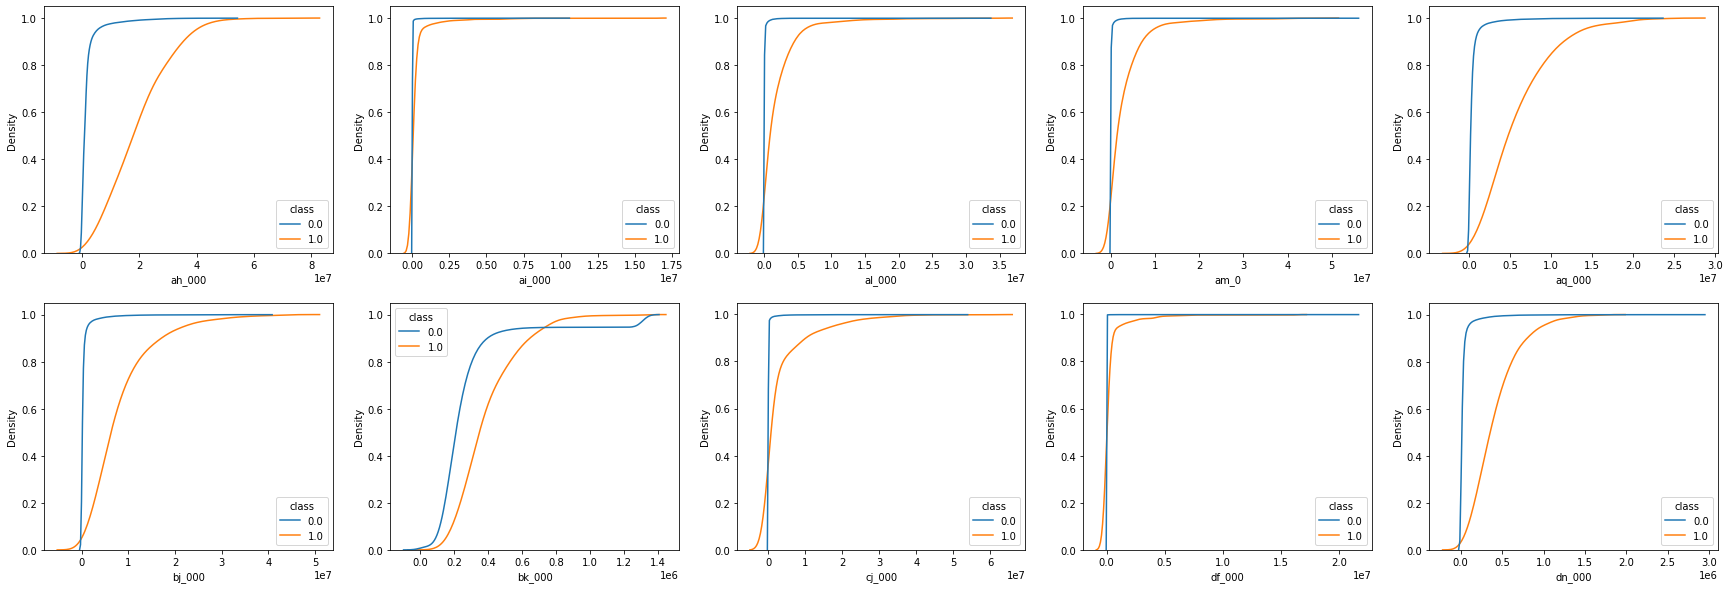

In [ ]:
cdf(num_features,top_num_features,2,5)

###Observations :
1. For features 'dn_000' , more than 95% of negative datapoints take feature values less than 0.1 x 10^6 and more that 90% of the positive datapoints take feature values greater than 0.1 x 10^6. 

2. For features [ 'ah_000' , 'aq_000' , 'bj_000' ], more than 95% of negative datapoints take feature values less than 0.1 x 10^7 and more that 90% of the positive datapoints take feature values greater than 0.1 x 10^7.

This means, almost 90% of datapoints can be correctly classified using these features, with 5% error. 

  

##Bivariate analysis on the top 5 numerical features

In [ ]:
num_features['class'] = df['class']
imp_num_features = num_features.dropna()
y = imp_num_features['class']
X = imp_num_features.drop('class',axis=1)
top_num_features_rfe = top_features_rfe(X,y,5) 
top_num_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
  if top_num_features_rfe[i]:
    top_num_features.append(hist_col[i]) 

print("Top histogram features are : ", top_num_features)
print("Total no of important features :", len(top_num_features))

Top histogram features are :  ['al_000', 'am_0', 'aq_000', 'bj_000', 'cj_000']
Total no of important features : 5


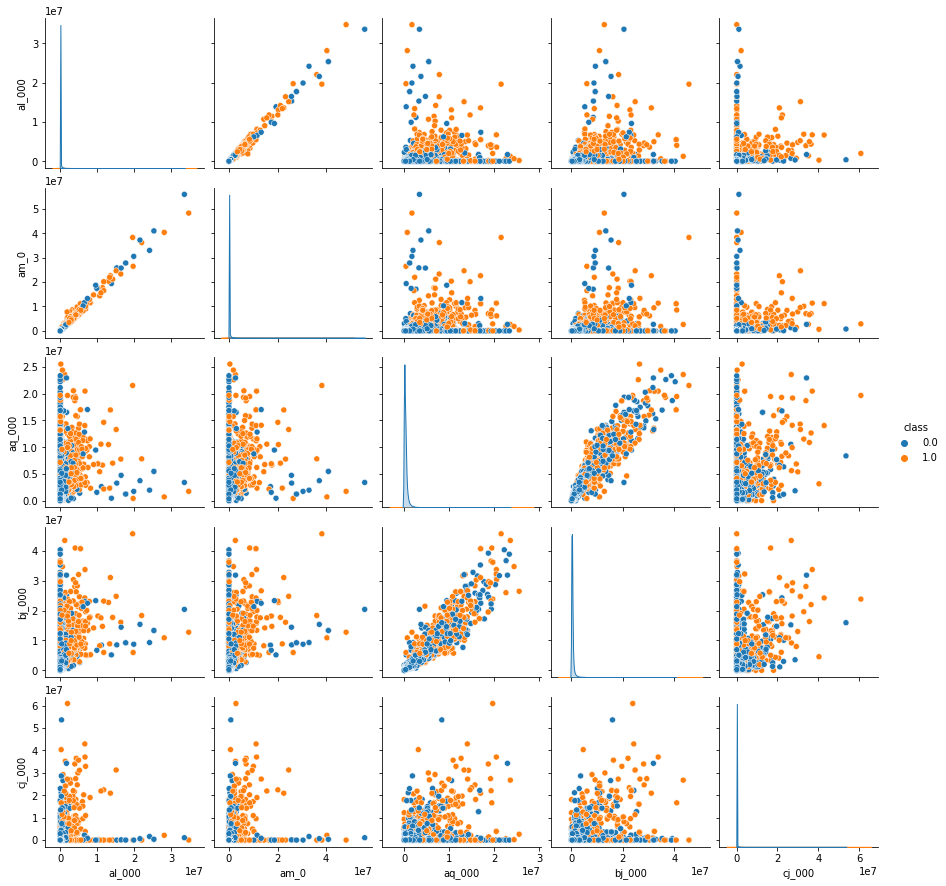

In [ ]:
a = ['al_000', 'am_0', 'aq_000', 'bj_000', 'cj_000','class']
sns.pairplot(num_features[a], hue='class')

###Observations :
1. If the value of features 'am_0' and 'al_000' is greater than 0.2 x 10^7 (approx), then chances are high that there is failure in APS system. 
Also these 2 features are highly uncorrelated with the other features. 

2. All the remaining plot have a lot of overlap and no clear conclusions can be drawn from it. 

##Summarizing the inferences from EDA
1. Data is highly imbalanced with almost 98% of datapoints belonging to negative class. 

2. Percentage of missing values in the data is extremely high. <br>8 features have missing values greater than 60%. <br>16 features have missing values between 20%-60%. <br>Remaining features have missing values less than 20%

3. Majority of feature values for negative datapoints is small compared to positive datapoints. This means if the feature values are high, then there is high chance of failure in the APS system.
4. Using the top histogram features ['ba_004', 'cn_004', 'cs_002', 'ee_005', 'ba_000'], around 60% of datapoints can be correctly clasified. 

5. Using the top numerical features [ 'ah_000' , 'aq_000' , 'bj_000' , 'dn_000' ], around 90% of datapoints can be correctly clasified.

6. Numerical features are found to be more good in classifying the datapoints compared to histogram features. 

7. A lot of multi collinearity exists between features. 

8. There are some negative datapoints with high features values making it difficult to classify between positive datapoints.   


#Missing Value Imputation
1. We will eliminate features with missing value greater than 60%. 

2. We will perform median imputation of features with missing values less than 20%

2. For the features between 20%-60% missing values, we will perform model based imputation called MICE imputation.

In [22]:
features_tobe_eliminated = []
median_imp_features = []
model_imp_features = []
for i in missing_feature_count.keys():
  percent = (missing_feature_count[i]/df_train.shape[0])
  if percent > 0.6:
    features_tobe_eliminated.append(i)
  elif percent < 0.2:
    median_imp_features.append(i)
  else:
    model_imp_features.append(i)

print("Features to be eliminated : ",features_tobe_eliminated)
print("Number of features to be eliminated : ",len(features_tobe_eliminated))
print("\nFeatures for model imputation : ",model_imp_features)
print("Number of features for model imputation : ",len(model_imp_features))
print("\nFeatures for median imputaton : ",median_imp_features)
print("Number of features for median imputaton : ",len(median_imp_features))

Features to be eliminated :  ['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000']
Number of features to be eliminated :  8

Features for model imputation :  ['bl_000', 'bk_000', 'ad_000', 'cf_000', 'cg_000', 'ch_000', 'co_000', 'ct_000', 'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000', 'db_000', 'dc_000']
Number of features for model imputation :  16

Features for median imputaton :  ['ec_00', 'cm_000', 'cl_000', 'ed_000', 'ak_000', 'ca_000', 'dm_000', 'df_000', 'dg_000', 'dh_000', 'dl_000', 'dj_000', 'dk_000', 'eb_000', 'di_000', 'ac_000', 'bx_000', 'cc_000', 'bd_000', 'ds_000', 'dt_000', 'dp_000', 'dq_000', 'dr_000', 'du_000', 'dv_000', 'bc_000', 'cp_000', 'de_000', 'do_000', 'dy_000', 'ef_000', 'ar_000', 'bz_000', 'dx_000', 'dz_000', 'ea_000', 'eg_000', 'be_000', 'dd_000', 'ce_000', 'ax_000', 'ae_000', 'af_000', 'av_000', 'bf_000', 'bs_000', 'cb_000', 'bu_000', 'bv_000', 'cq_000', 'dn_000', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_

###Train and CV split

In [108]:
X = df_train.drop('class',axis=1)
y = df_train['class']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_test = df_test.drop('class',axis=1)
y_test = df_test['class']

X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_cv.reset_index(drop=True,inplace=True)
y_cv.reset_index(drop=True,inplace=True)
print(10*'='+" Train Data "+10*'=')
print(X_train.shape)
print(y_train.shape)

print(10*'='+" CV Data "+10*'=')
print(X_cv.shape)
print(y_cv.shape)

print(10*'='+" Test Data "+10*'=')
print(X_test.shape)
print(y_test.shape)

========== Train Data ==========
(41999, 169)
(41999,)
========== CV Data ==========
(18000, 169)
(18000,)
========== Test Data ==========
(16000, 169)
(16000,)


###Median Imputation on features with less than 20% missing values

In [ ]:
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train[median_imp_features])

X_train_median = median_imputer.transform(X_train[median_imp_features])
X_cv_median = median_imputer.transform(X_cv[median_imp_features])
X_test_median = median_imputer.transform(X_test[median_imp_features])

###Model Based Imputation on features greater than 20% missing values 

In [110]:
X_train_mice = X_train.copy()
X_train_mice[median_imp_features] = X_train_median
X_train_mice = X_train_mice.drop(features_tobe_eliminated,axis=1)
print(X_train_mice.shape)

X_cv_mice = X_cv.copy()
X_cv_mice[median_imp_features] = X_cv_median
X_cv_mice = X_cv_mice.drop(features_tobe_eliminated,axis=1)
print(X_cv_mice.shape)

X_test_mice = X_test.copy()
X_test_mice[median_imp_features] = X_test_median
X_test_mice = X_test_mice.drop(features_tobe_eliminated,axis=1)
print(X_test_mice.shape)

(41999, 161)
(18000, 161)
(16000, 161)


####Normalizing the dataset before MICE imputation :
Since MICE is also a model based imputation technique and uses linear regression in learning the missing values, we will Normalize the data before imputation.

In [ ]:
def normalize(df):
  x = df.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  return x_scaled, min_max_scaler

In [ ]:
X_train_scaled, scaler = normalize(X_train_mice)
X_cv_scaled = scaler.transform(X_cv_mice)
X_test_scaled = scaler.transform(X_test_mice)

X_train_mice = pd.DataFrame(X_train_scaled, columns= X_train_mice.columns)
X_cv_mice = pd.DataFrame(X_cv_scaled, columns= X_cv_mice.columns)
X_test_mice = pd.DataFrame(X_test_scaled, columns= X_test_mice.columns)

####MICE Imputation

In [ ]:
def mice_imputation(df):
  mice_imputer = IterativeImputer(random_state=42)
  df_imputed = mice_imputer.fit_transform(df)
  #df_imputed = pd.DataFrame(df_imputed,columns=df.columns)
  return df_imputed, mice_imputer

In [ ]:
X_train_imputed, mice_imputer = mice_imputation(X_train_mice)
X_cv_imputed = mice_imputer.transform(X_cv_mice)
X_test_imputed = mice_imputer.transform(X_test_mice)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_mice.columns)
X_cv_imputed = pd.DataFrame(X_cv_imputed, columns=X_cv_mice.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_mice.columns)

####Storing the Imputed Dataset as csv file and imputer models as pickle file

In [104]:
X_train_imputed['class'] = y_train
X_cv_imputed['class'] = y_cv
X_test_imputed['class'] = y_test

X_train_imputed.to_csv('train_mice_imputed.csv',index=False) #Storing the imputed dataframe as csv file. 
X_cv_imputed.to_csv('cv_mice_imputed.csv',index=False)
X_test_imputed.to_csv('test_mice_imputed.csv',index=False)

pickle.dump(median_imputer,open('median_imputer.pkl','wb'))
pickle.dump(scaler,open('normalizer.pkl','wb'))
pickle.dump(mice_imputer,open('mice_imputer.pkl','wb'))

####Loading the Mice Imputed Dataset 

In [105]:
train_mice_imputed = pd.read_csv('train_mice_imputed.csv')
cv_mice_imputed = pd.read_csv('cv_mice_imputed.csv')
test_mice_imputed = pd.read_csv('test_mice_imputed.csv')

#Feature Engineering 

##Using Auto Encoders on Mice Imputed Dataset to get a compressed representation of Data 

Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.

An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.

The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model.

###Defining Encoder Decoder Model
1. We will define the encoder to have two hidden layers, the first with two times the number of inputs (here 161 x 2 = 322) and the second with the same number of inputs (here 161), followed by the bottleneck layer with size 50. i.e. we are compressing the data from 161 dimension to 50 dimensions. 

2. To ensure the model learns well, we will use batch normalization and leaky ReLU activation.

3. The decoder will be defined with a similar structure, although in reverse.
It will have two hidden layers, the first with the number of inputs in the dataset (here 361) and the second with double the number of inputs (here 361 x 2 = 322). The output layer will have the same number of nodes as there are columns in the input data and will use a linear activation function to output numeric values.

4. The model will be fit using Adam optimizer and tries to minimizes the mean squared error. 

Epoch 1/50
3000/3000 - 19s - loss: 0.0033 - val_loss: 8.8554e-04
Epoch 2/50
3000/3000 - 17s - loss: 7.4591e-04 - val_loss: 5.9236e-04
Epoch 3/50
3000/3000 - 17s - loss: 6.1516e-04 - val_loss: 4.9089e-04
Epoch 4/50
3000/3000 - 17s - loss: 5.2188e-04 - val_loss: 7.2145e-04
Epoch 5/50
3000/3000 - 17s - loss: 4.4059e-04 - val_loss: 2.8249e-04
Epoch 6/50
3000/3000 - 17s - loss: 3.8568e-04 - val_loss: 2.1784e-04
Epoch 7/50
3000/3000 - 17s - loss: 3.3596e-04 - val_loss: 2.4118e-04
Epoch 8/50
3000/3000 - 17s - loss: 2.9757e-04 - val_loss: 2.1816e-04
Epoch 9/50
3000/3000 - 17s - loss: 2.6324e-04 - val_loss: 1.9694e-04
Epoch 10/50
3000/3000 - 17s - loss: 2.4923e-04 - val_loss: 2.2265e-04
Epoch 11/50
3000/3000 - 16s - loss: 2.3133e-04 - val_loss: 2.0822e-04
Epoch 12/50
3000/3000 - 17s - loss: 2.0627e-04 - val_loss: 2.2210e-04
Epoch 13/50
3000/3000 - 17s - loss: 2.0572e-04 - val_loss: 2.9566e-04
Epoch 14/50
3000/3000 - 17s - loss: 1.8827e-04 - val_loss: 1.4497e-04
Epoch 15/50
3000/3000 - 17s - los

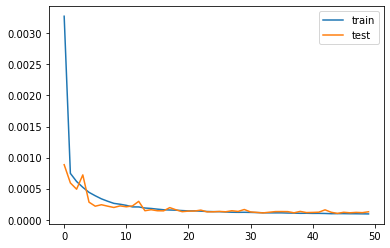

In [ ]:
# train autoencoder for classification with with compression in the bottleneck layer
#https://machinelearningmastery.com/autoencoder-for-classification/
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
# define dataset
X_train = train_mice_imputed.drop('class',axis=1)
X_cv = cv_mice_imputed.drop('class',axis=1)
# number of input columns
n_inputs = X_train.shape[1]
# split into train test sets


# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 50
bottleneck = Dense(n_bottleneck)(e)

# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_cv,X_cv))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# save the encoder to file
encoder.save('mice_encoder.h5')

In [ ]:
from tensorflow.keras.models import load_model
encoder = load_model('mice_encoder.h5')

###Encoding the Train, CV, Test Data
1. Using the encoder part of the model, we will encode the train,cv and test data to have 50 dimensions. 

2. We will use this 50 dimensional features as additional features to our existing data. So we will get total features equal to 361+50 = 211.

In [246]:
# encoding the train data
print('='*20+'Train Data'+'='*20)
X_train_encode = encoder.predict(train_mice_imputed.drop('class',axis=1))
print(X_train_encode.shape)
X_train_mice_final = np.hstack((np.array(train_mice_imputed.drop('class',axis=1)),X_train_encode))
print(X_train_mice_final.shape)
y_train_mice_final = train_mice_imputed['class']
print(y_train_mice_final.shape)

#encoding cv data
print('='*20+'CV Data'+'='*20)
X_cv_encode = encoder.predict(cv_mice_imputed.drop('class',axis=1))
print(X_cv_encode.shape)
X_cv_mice_final = np.hstack((np.array(cv_mice_imputed.drop('class',axis=1)),X_cv_encode))
print(X_cv_mice_final.shape)
y_cv_mice_final = cv_mice_imputed['class']
print(y_cv_mice_final.shape)

#encoding test data
print('='*20+'Test Data'+'='*20)
X_test_encode = encoder.predict(test_mice_imputed.drop('class',axis=1))
print(X_test_encode.shape)
X_test_mice_final = np.hstack((np.array(test_mice_imputed.drop('class',axis=1)),X_test_encode))
print(X_test_mice_final.shape)
y_test_mice_final = test_mice_imputed['class']
print(y_test_mice_final.shape)

====================Train Data====================
(41999, 50)
(41999, 211)
(41999,)
====================CV Data====================
(18000, 50)
(18000, 211)
(18000,)
====================Test Data====================
(16000, 50)
(16000, 211)
(16000,)


###Oversampling using SMOTE on mice imputed train dataset
1. We will oversample minority class by 50% of majority class.

2. Afterwards, we will undersample the majority class to reduce the number of examples in the majority class to have around 60 percent more than the minority class. 

3. The original paper on SMOTE and various experiments suggests that combination of oversampling and undersampling is more effective than using oversampling of minority class alone. 

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.5,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train_mice_final, y_train_mice_final = pipeline.fit_resample(X_train_mice_final, y_train_mice_final)

In [ ]:
pd.DataFrame(y_train_mice_final).value_counts()

0.0    34415
1.0    20649
dtype: int64

In [119]:
print('Dataset after balancing using SMOTE ')
print('='*20+'Train Data'+'='*20)
print(X_train_mice_final.shape)
print(y_train_mice_final.shape)
print('='*20+'CV Data'+'='*20)
print(X_cv_mice_final.shape)
print(y_cv_mice_final.shape)
print('='*20+'Test Data'+'='*20)
print(X_test_mice_final.shape)
print(y_test_mice_final.shape)

Dataset after balancing using SMOTE 
====================Train Data====================
(55064, 211)
(55064,)
====================CV Data====================
(18000, 211)
(18000,)
====================Test Data====================
(16000, 211)
(16000,)


###Saving the dataset as pickle files

In [248]:
pickle.dump((X_train_mice_final,y_train_mice_final),open('mice_train_data.pkl','wb'))
pickle.dump((X_cv_mice_final,y_cv_mice_final),open('mice_cv_data.pkl','wb'))
pickle.dump((X_test_mice_final,y_test_mice_final),open('mice_test_data.pkl','wb'))

##Summarizing key points from feature engineering
1. The original dataset after data preprocessing is left with 161 features. 

2. Using Auto Encoder neural network, we reduced these features from 161 dimension to 50 dimension. This is a compressed representation of original data. 

3. Then we added these encoder features to our original dataset, thereby taking the feature numbers to 211 (161 +50). 

4. The imbalance in train dataset is dealt using the technique called SMOTE. <br>Using SMOTE, the minority class was upsampled by 50% of majority class. Then the majority class was undersampled thereby reducing the number of samples in the majority class to have 50 percent more than the minority class. 



#Modelling on mice imputed dataset

In [259]:
X_train, y_train = pickle.load(open('mice_train_data.pkl', 'rb'))
X_cv,y_cv = pickle.load(open('mice_cv_data.pkl', 'rb'))
X_test, y_test = pickle.load(open('mice_test_data.pkl', 'rb'))

In [260]:
print('='*20+'Train Data'+'='*20)
print(X_train.shape)
print(y_train.shape)
print('='*20+'CV Data'+'='*20)
print(X_cv.shape)
print(y_cv.shape)
print('='*20+'Test Data'+'='*20)
print(X_test.shape)
print(y_test.shape)

====================Train Data====================
(55064, 211)
(55064,)
====================CV Data====================
(18000, 211)
(18000,)
====================Test Data====================
(16000, 211)
(16000,)


##Some plotting functions defined for modelling

In [261]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
#Function to plot confusion matrix in heatmaps
def cm_heatmap(cm):
  A =(((cm.T)/(cm.sum(axis=1))).T)
  B =(cm/cm.sum(axis=0))
  labels = [0,1]
  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1);
  sns.heatmap(cm, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels);
  # labels, title and ticks
  plt.xlabel('Predicted labels');
  plt.ylabel('True labels'); 
  plt.title('Confusion Matrix');
  
  plt.subplot(1,3,2)
  sns.heatmap(B, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels');
  plt.ylabel('True labels'); 
  plt.title('Precision Matrix');


  ax = plt.subplot(1,3,3)
  sns.heatmap(A, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels');
  plt.ylabel('True labels'); 
  plt.title('Recall Matrix');


In [262]:
def cv_plot(results,alpha):
  train_score = results['mean_train_score']
  cv_score = results['mean_test_score']

  plt.plot(alpha, train_score, label='Train f1-macro')
  plt.plot(alpha, cv_score, label='CV f1-macro')

  plt.scatter(alpha, train_score, label='Train f1-macro')
  plt.scatter(alpha, cv_score, label='CV f1-macro')

  plt.legend()
  plt.xlabel("alpha: hyperparameter")
  plt.ylabel("f1-macro")
  plt.title("ERROR PLOTS")
  plt.grid()
  plt.show()

In [263]:
def best_prob(y_predicted,y_actual,p):
  y_pred=[]
  cost_list=[]
  for i in p:
    for j in y_predicted:
      if j>=i:
        y_pred.append(1)
      else:
        y_pred.append(0)

    cm = confusion_matrix(y_actual,y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = (10 * fp) + (500 * fn)
    cost_list.append(cost)
    y_pred=[]
  best_cost = min(cost_list)
  best_p = p[cost_list.index(best_cost)]
  return best_p


##Baseline Approach
1. We will create a random model (dumb model) that will classify all datapoints to belong to majority class (negative). Using this model we will get the worst value for our metric which is macro f1 score. Using this f1 score we can check the performance of other conventional models. 

2. We will train the dataset on conventional models like Logistic Regression, Linear SVM, Decision Trees, Random Forest and XGBoost. 

3. We will perform hyperparameter tuning on all the above models using GridSearcCV and RandomizedSearchCV. We will then retrain the models on the best parameter values that we get from hyperparameter tuning. Then we will calculate the macro f1 score on Train, CV and Test data for all these models.

4. In our problem, the cost of false negatives (FN) is higher than cost of false positives (FP). This means, more importance should be given to recall compared to precision. <br>So we will have to change the probability threshold from the default value 0.5. 

5. The cost metric mentioned in the problem is <br> Cost = (10 x FP) + (500 x FN). <br>The correct probability threshold will be the one that gives minimum cost. 

6. We will use sklearn's precision recall curve to get the threshold values. 
Precison recall curve computes precision-recall pairs for different probability thresholds. <br>
Using these probability thresholds we will compute the cost and we will take that probability value that gives minimum cost. We will use Cross Validation Data for this probability threshold value. 

7. Using this probability threshold, we will predict the class labels for Train, CV and Test Data and compute the Train, CV and Test cost for all the models. The model that gives minimum Test Cost will be taken as the best model.  

###Baseline Random Model 

Macro average f1-score :  0.49407114624505927
Cost :  187500


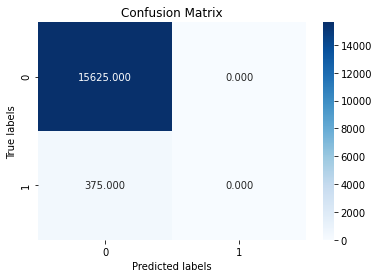

In [ ]:
n = y_test.shape[0]
y_test_pred = np.zeros(n)
cm = confusion_matrix(y_test,y_test_pred)
labels=[0,1]
sns.heatmap(cm, annot=True, fmt=".3f",cmap='Blues',xticklabels=labels, yticklabels=labels);
# labels, title and ticks
plt.xlabel('Predicted labels');
plt.ylabel('True labels'); 
plt.title('Confusion Matrix');
  
f1_scr = f1_score(y_test,y_test_pred, average = 'macro')
print("Macro average f1-score : ", f1_scr)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Cost : ", cost)

###Logistic regression model

{'alpha': 0.001}


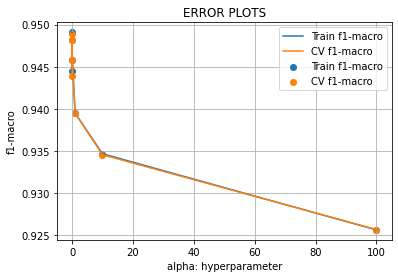

In [264]:
alpha = [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]
param = {'alpha' : alpha}
clf = SGDClassifier(loss='log', n_jobs=-1, random_state = 42, class_weight='balanced')
tuning = GridSearchCV(estimator=clf,param_grid=param,cv=5,scoring='f1_macro',n_jobs=-1,return_train_score=True)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)
cv_plot(tuning.cv_results_,alpha)

In [265]:
best_LR_model = SGDClassifier(alpha=0.001,loss='log' , n_jobs = -1, random_state=42, class_weight= 'balanced')
calib_LR = CalibratedClassifierCV(base_estimator=best_LR_model, cv=10, method='sigmoid')
calib_LR.fit(X_train,y_train)

y_pred = calib_LR.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_LR.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_LR.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9457600141580993
Macro average f1-score on CV Data :  0.7434537178756837
Macro average f1-score on Test Data :  0.7953904966558553


Best probability Threshold is :  0.29431586047001196
Train Cost :  436760
CV Cost :  15990
Test Cost :  16850


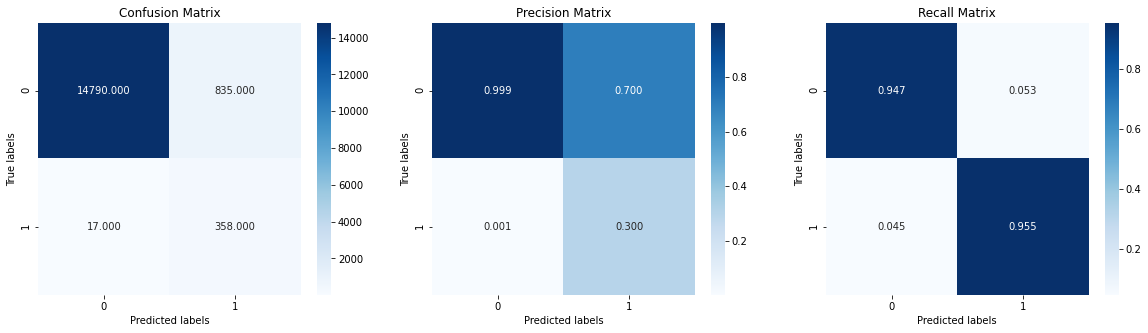

In [266]:
y_train_pred = calib_LR.predict_proba(X_train)[:,1] 
y_cv_pred = calib_LR.predict_proba(X_cv)[:,1]
y_test_pred = calib_LR.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

###Linear SVM

{'alpha': 0.001}


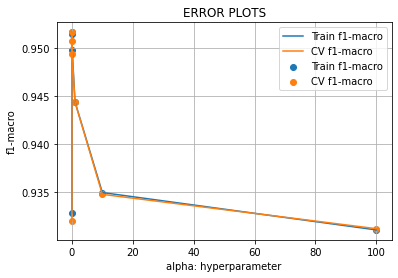

In [267]:
alpha = [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]
param = {'alpha' : alpha}
clf = SGDClassifier(loss='hinge',class_weight = 'balanced', n_jobs=-1, random_state = 42)
tuning = GridSearchCV(estimator=clf,param_grid=param,cv=5,scoring='f1_macro',n_jobs=-1,return_train_score=True)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)
cv_plot(tuning.cv_results_,alpha)

In [268]:
best_SVM_model = SGDClassifier(alpha=0.001,loss='hinge',class_weight = 'balanced' , n_jobs = -1, random_state=42)
calib_SVM = CalibratedClassifierCV(base_estimator=best_SVM_model, cv=5, method='sigmoid')
calib_SVM.fit(X_train,y_train)

y_pred = calib_SVM.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_SVM.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_SVM.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.942606613417736
Macro average f1-score on CV Data :  0.7624630687879626
Macro average f1-score on Test Data :  0.815556779999095


Best probability Threshold is :  0.23983161400221223
Train Cost :  328380
CV Cost :  15750
Test Cost :  15050


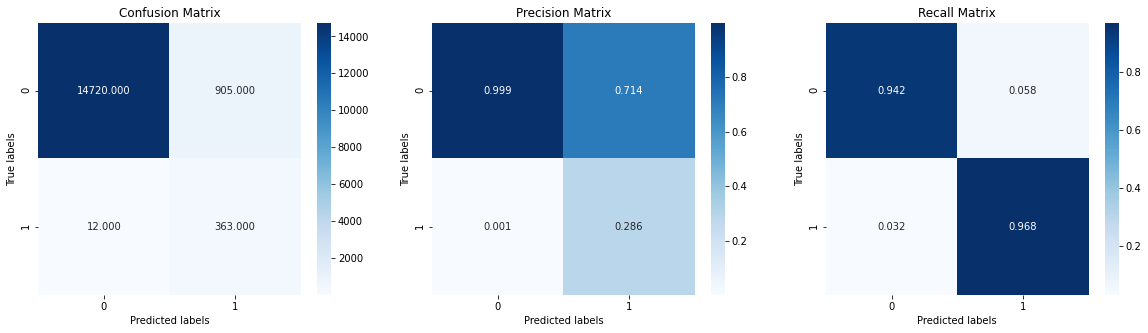

In [269]:
y_train_pred = calib_SVM.predict_proba(X_train)[:,1] 
y_cv_pred = calib_SVM.predict_proba(X_cv)[:,1]
y_test_pred = calib_SVM.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)


###Decision Trees

In [309]:
max_depth = [2, 5, 10, 30, 50]
min_samples_split = [2, 5, 10, 50, 100]
param = {'max_depth':max_depth,'min_samples_split':min_samples_split}
clf = DecisionTreeClassifier(class_weight = 'balanced' , random_state=42)
tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


{'min_samples_split': 10, 'max_depth': 30}


In [310]:
best_DT_model = DecisionTreeClassifier(max_depth = 30, min_samples_split = 10, class_weight = 'balanced' , random_state=42)

calib_DT = CalibratedClassifierCV(base_estimator=best_DT_model, cv=3, method='sigmoid')
calib_DT.fit(X_train,y_train)


y_pred = calib_DT.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_DT.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_DT.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9961890854789496
Macro average f1-score on CV Data :  0.7751511410081744
Macro average f1-score on Test Data :  0.813172505998914


Best probability Threshold is :  0.026614244860149624
Train Cost :  8870
CV Cost :  24050
Test Cost :  28270


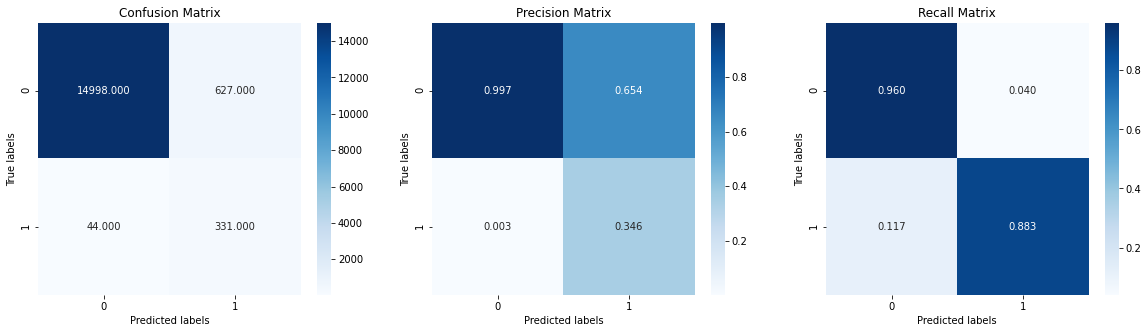

In [311]:
y_train_pred = calib_DT.predict_proba(X_train)[:,1] 
y_cv_pred = calib_DT.predict_proba(X_cv)[:,1]
y_test_pred = calib_DT.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

###Random Forest Model

In [ ]:
max_depth = [5, 10,20, 50]
n_estimators = [10,25,50,80,100]
min_samples_split = [2,5,10,50]
param = {'max_depth':max_depth,'n_estimators':n_estimators,'min_samples_split':min_samples_split}
clf = RandomForestClassifier(class_weight = 'balanced' , random_state=42)
tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)

In [272]:
best_RF_model = RandomForestClassifier(max_depth = 50, n_estimators =80 ,min_samples_split=2,n_jobs=-1,class_weight = 'balanced' , random_state=42, criterion='gini')
calib_RF = CalibratedClassifierCV(base_estimator=best_RF_model, cv=3, method='sigmoid')
calib_RF.fit(X_train,y_train)

y_pred = calib_RF.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_RF.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_RF.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)


Macro average f1-score on Train Data :  0.9999225114049164
Macro average f1-score on CV Data :  0.8604703618482058
Macro average f1-score on Test Data :  0.885289378874095


Best probability Threshold is :  0.005551333393319321
Train Cost :  7830
CV Cost :  10880
Test Cost :  8820


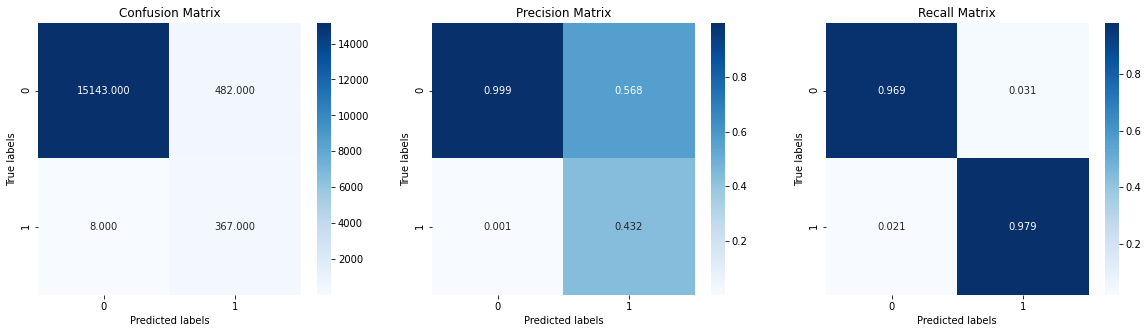

In [273]:
y_train_pred = calib_RF.predict_proba(X_train)[:,1]
y_cv_pred = calib_RF.predict_proba(X_cv)[:,1]
y_test_pred = calib_RF.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)
#p=0.0043239001245260035
#p = 0.007350330186295411
print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

###XGBoost Model

In [284]:
max_depth = [5,10,20, 30, 50]
n_estimators = [10,30,50,80,100,250]
colsample_bytree = [0.3,0.5,0.7,1]
subsample = [0.5,0.5,0.7,1]

param = {'max_depth':max_depth,'n_estimators':n_estimators, 'colsample_bytree':colsample_bytree,'subsample':subsample}
clf = xgb.XGBClassifier(n_jobs=-1, random_state=42, scale_pos_weight = 1.7 )
tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.4min finished


{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 30, 'colsample_bytree': 1}


In [285]:
best_XGB_model = xgb.XGBClassifier(max_depth = 30, n_estimators =100 , n_jobs=-1, random_state=42, scale_pos_weight = 1.7, subsample=0.5,colsample_bytree=1 )
calib_XGB = CalibratedClassifierCV(base_estimator=best_XGB_model, cv=5, method='sigmoid')
calib_XGB.fit(X_train,y_train)

y_pred = calib_XGB.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_XGB.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_XGB.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9998643962724054
Macro average f1-score on CV Data :  0.8805705627811651
Macro average f1-score on Test Data :  0.9106868889844422


Best probability Threshold is :  0.0005618015068166171
Train Cost :  7260
CV Cost :  10620
Test Cost :  10910


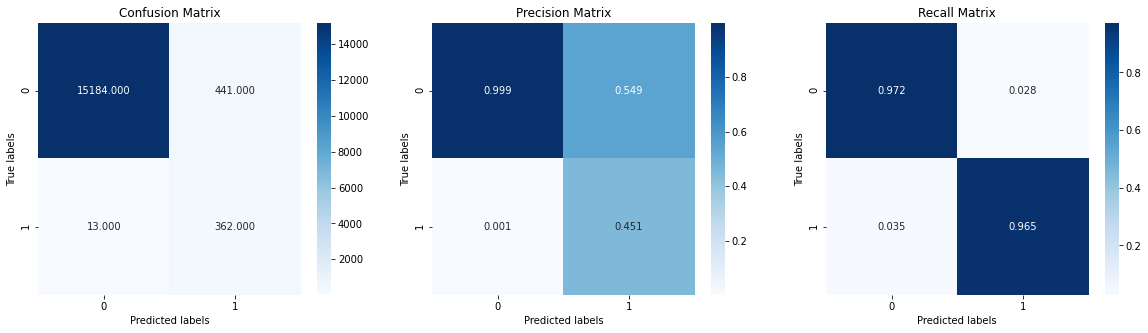

In [286]:
y_train_pred = calib_XGB.predict_proba(X_train)[:,1] 
y_cv_pred = calib_XGB.predict_proba(X_cv)[:,1]
y_test_pred = calib_XGB.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

###AdaBoost Classifier

In [288]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [10,30,50,80,100,250]
learning_rate = [0.001,0.01,0.1,1,10]
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
LR = LogisticRegression()
base_estimator = [DT,RF,LR]
param = {'n_estimators':n_estimators, 'learning_rate':learning_rate,'base_estimator':base_estimator}
clf = AdaBoostClassifier( random_state=42)
tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
tuning.fit(X_train,y_train)
best = tuning.best_params_
print(best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.5min finished


{'n_estimators': 50, 'learning_rate': 0.01, 'base_estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}


In [289]:
best_Ada_model = AdaBoostClassifier(n_estimators =50, learning_rate=0.01, base_estimator=RandomForestClassifier(),random_state=42)
calib_Ada = CalibratedClassifierCV(base_estimator=best_Ada_model, cv=3, method='sigmoid')
calib_Ada.fit(X_train,y_train)

y_pred = calib_Ada.predict(X_train)
f1_scr = f1_score(y_train,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_Ada.predict(X_cv)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_Ada.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9997675206970078
Macro average f1-score on CV Data :  0.8676569936011985
Macro average f1-score on Test Data :  0.8975836133781404


Best probability Threshold is :  0.24115223894192717
Train Cost :  2710
CV Cost :  10000
Test Cost :  10780


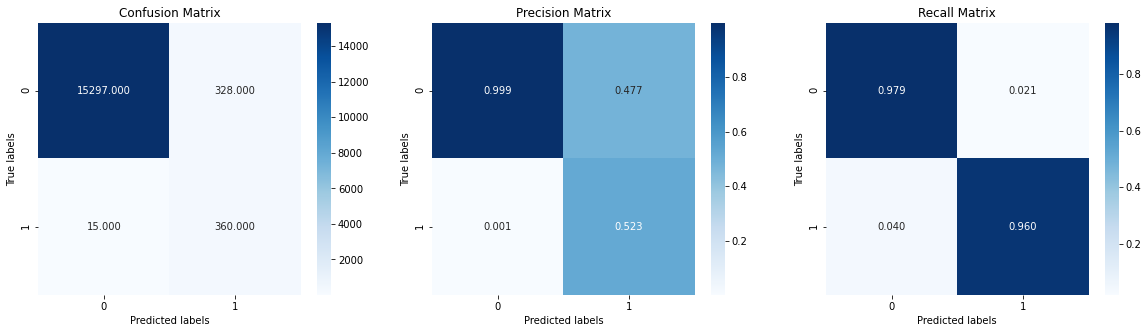

In [290]:
y_train_pred = calib_Ada.predict_proba(X_train)[:,1] 
y_cv_pred = calib_Ada.predict_proba(X_cv)[:,1]
y_test_pred = calib_Ada.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_train,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

###Custom Ensemble

####Splitting the train dataset

In [291]:
D1,D2,y1,y2 = train_test_split(X_train,y_train,random_state=42,test_size=0.5,stratify=y_train)
print('='*20 + 'Train Dataset'+'='*20)
print(X_train.shape)
print(y_train.shape)
print('='*20 + 'Dataset D1'+'='*20)
print(D1.shape)
print(y1.shape)
print('='*20 + 'Dataset D2'+'='*20)
print(D2.shape)
print(y2.shape)

====================Train Dataset====================
(55064, 211)
(55064,)
====================Dataset D1====================
(27532, 211)
(27532,)
====================Dataset D2====================
(27532, 211)
(27532,)


####Generating k Samples from Dataset D1

In [292]:
def generating_samples(input_data, target_data,size):
  selected_rows = np.random.choice(len(input_data),round(size*len(input_data)),replace=True)
  sample_x = input_data[selected_rows]
  sample_y = target_data[selected_rows]
  return sample_x,sample_y

In [293]:
def generating_k_samples(X,y,k,size):
  list_input_data =[]
  list_output_data =[]

  for i in range(k):
    a,b = generating_samples(X,y,size)
    list_input_data.append(a)
    list_output_data.append(b)
  return list_input_data,list_output_data

####Generating k models trained on k samples

In [294]:
def train(list_input_data,list_output_data):
  list_of_all_models = []
  for i in range(len(list_input_data)):
    reg = DecisionTreeClassifier()
    model = reg.fit(list_input_data[i],list_output_data[i])
    list_of_all_models.append(model)
  return list_of_all_models

####Getting predictions from k-models on Dataset D2

In [295]:
def prediction(models,X):
  y_pred=[]
  for model in models:
    y_pred.append(model.predict(X))
  y_pred=np.array(y_pred)
  return y_pred.T

####Defining the custom ensemble model

In [296]:
def custom_ensemble(D1,D2,y1,y2,k,size,X_cv,y_cv):
  k_samples_x,k_samples_y = generating_k_samples(D1,y1,k,size)
  models = train(k_samples_x,k_samples_y)
  k_pred = prediction(models,D2)

  meta_model = RandomForestClassifier() #defining metamodel
  meta_model.fit(k_pred,y2)

  X_cv_k_pred = prediction(models,X_cv)
  y_cv_pred = meta_model.predict(X_cv_k_pred)
  return y_cv_pred

####Hyper parameter tuning for custom ensemble model

In [297]:
def parameter_tuning(D1,D2,y1,y2,X_cv,y_cv):
  k=[10,30,50,80,100]
  size = [0.3,0.5,0.7]
  #train_f1_scr=[]
  cv_f1_scr=[]
  k_and_size=[]
  for i in tqdm(k):
    for j in size:
      y_cv_pred = custom_ensemble(D1,D2,y1,y2,i,j,X_cv,y_cv)
      #train_f1_scr.append(f1_score(y2,y_train_pred, average = 'macro'))
      cv_f1_scr.append(f1_score(y_cv,y_cv_pred, average = 'macro'))
      k_and_size.append([i,j])
  best_params = {'n_estimators' : k_and_size[cv_f1_scr.index(max(cv_f1_scr))][0],'sample_size':k_and_size[cv_f1_scr.index(max(cv_f1_scr))][1]}
  print(best_params)

In [298]:
parameter_tuning(D1,D2,y1,y2,X_cv,y_cv)

100%|██████████| 5/5 [1:02:49<00:00, 753.97s/it]

{'n_estimators': 80, 'sample_size': 0.5}


####Hyperparameter tuning for meta model

In [313]:
def meta_model_tuning(D1,D2,y1,y2,k,size):
  max_depth = [5, 10,20, 50]
  n_estimators = [10,25,50,80,100]
  min_samples_split = [2,5,10,50]

  k_samples_x,k_samples_y = generating_k_samples(D1,y1,k,size)
  models = train(k_samples_x,k_samples_y)
  k_pred = prediction(models,D2)

  param = {'max_depth':max_depth,'n_estimators':n_estimators,'min_samples_split':min_samples_split}
  clf = RandomForestClassifier(class_weight = 'balanced' , random_state=42)
  tuning = RandomizedSearchCV(estimator=clf,param_distributions=param,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
  tuning.fit(k_pred,y2)
  best = tuning.best_params_
  print(best)

In [314]:
n_estimators = 80
sample_size = 0.5
meta_model_tuning(D1,D2,y1,y2,n_estimators,sample_size)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.3s finished


{'n_estimators': 80, 'min_samples_split': 2, 'max_depth': 20}


####Final Training using best parameters

In [315]:
k_samples_x,k_samples_y = generating_k_samples(D1,y1,n_estimators,sample_size)
models = train(k_samples_x,k_samples_y)
train_k_pred = prediction(models,D2)
best_meta_model = RandomForestClassifier(n_estimators=80,min_samples_split=2,max_depth=20,class_weight='balanced',random_state=42)
calib_CE = CalibratedClassifierCV(base_estimator=best_meta_model, cv=3, method='sigmoid')
calib_CE.fit(train_k_pred,y2)

y_pred = calib_CE.predict(train_k_pred)
f1_scr = f1_score(y2,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

cv_k_pred = prediction(models,X_cv)
y_pred = calib_CE.predict(cv_k_pred)
f1_scr = f1_score(y_cv,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

test_k_pred = prediction(models,X_test)
y_pred = calib_CE.predict(test_k_pred)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9990315051160612
Macro average f1-score on CV Data :  0.8195159600818043
Macro average f1-score on Test Data :  0.8595234158761047


Best probability Threshold is :  0.0058249133363609705
Train Cost :  5710
CV Cost :  12230
Test Cost :  12420


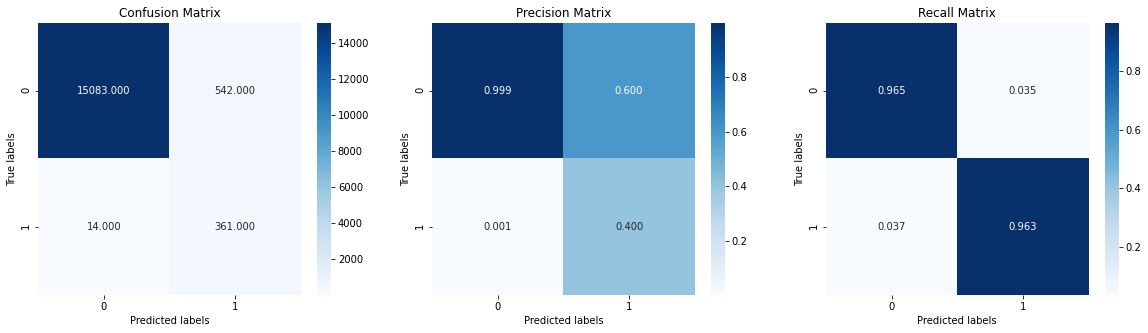

In [316]:
y_train_pred = calib_CE.predict_proba(train_k_pred)[:,1] 
y_cv_pred = calib_CE.predict_proba(cv_k_pred)[:,1] 
y_test_pred = calib_CE.predict_proba(test_k_pred)[:,1] 

precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred)
p = best_prob(y_cv_pred,y_cv,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y2,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_cv,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
  if i>=p:
    y_pred.append(1)
  else:
    y_pred.append(0)
  
cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

##Summary of Results from Models

In [317]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = [ 'Model' , 'Probability Threshold' ,'Test Cost']
table.add_row(['Random Model' , '-',187500])
table.add_row(['Logistic Regression Model' , 0.29431, 16850])
table.add_row(['Linear SVM Model' , 0.23983,15050])
table.add_row(['Decision Tree Model' , 0.02661,28270])
table.add_row(['Random Forest Model' , 0.00555,8820])
table.add_row(['XGBoost Model' , 0.00056,10910])
table.add_row(['AdaBoost Model' , 0.24115,10780])
table.add_row(['Custom Ensemble' , 0.00582,12420])
print(table)

+---------------------------+-----------------------+-----------+
|           Model           | Probability Threshold | Test Cost |
+---------------------------+-----------------------+-----------+
|        Random Model       |           -           |   187500  |
| Logistic Regression Model |        0.29431        |   16850   |
|      Linear SVM Model     |        0.23983        |   15050   |
|    Decision Tree Model    |        0.02661        |   28270   |
|    Random Forest Model    |        0.00555        |    8820   |
|       XGBoost Model       |        0.00056        |   10910   |
|       AdaBoost Model      |        0.24115        |   10780   |
|      Custom Ensemble      |        0.00582        |   12420   |
+---------------------------+-----------------------+-----------+


__Random Forest Model with a probability threshold value of 0.00555 is gives a minimum cost of 8820. This is the best model.__